## Evaluate result sensitivity to params

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import matplotlib.pylab as plt

In [2]:
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.deconvolution_plotter import *

# Configuration

In [3]:
device = torch.device("cpu:0")
dtype = torch.float32
dtype_np = np.float32
n_iters = 1_000

# Load data

In [4]:
machine_name = 'remote'
    
if machine_name == 'remote':
    sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/02-EBOV_bulk/load_data_python/ebov_sc.h5ad"
    bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/02-EBOV_bulk/load_data_python/ebov_bulk.h5ad"
if machine_name == 'local':
    bulk_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
    sc_anndata_path = "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [5]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
# select samples only after or on tp 0 
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [8]:
def evaluate_deconvolution(sc_anndata, bulk_anndata, hyperparameters = None, n_iters = 1_000):
    ebov_dataset = DeconvolutionDataset(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = bulk_anndata,
        bulk_time_col = "dpi_time",
        dtype_np = dtype_np,
        dtype = dtype,
        device=device,
        feature_selection_method = 'single_cell_od',
        verbose=False,

    )
    
    pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
        dataset=ebov_dataset,
        trajectory_model_type='gp',
        device=device,
        dtype=dtype,
        hyperparameters = hyperparameters,
    )
    
    pseudo_time_reg_deconv.fit_model(
        n_iters=n_iters, 
        verbose=False, 
        log_frequency=1000,
        keep_param_store_history=False,
        clear_param_store=True)
    
    traj = pseudo_time_reg_deconv.population_proportion_model.get_composition_trajectories(
                pseudo_time_reg_deconv.dataset, n_intervals=100
            )
    
    return traj

### Vary beta prior scale

In [9]:
start = 1.
end = 10.
num = 10

results = {}

for i, v in enumerate(np.linspace(start, end, num)):
    print(f'Evaluating with beta_prior_scale = {v} ...')
    p = TimeRegularizedDeconvolutionModelParametrization()
    p.log_beta_prior_scale = v
    results[v] = evaluate_deconvolution(sc_anndata, bulk_anndata, hyperparameters = p, n_iters = 10_000)

Evaluating with beta_prior_scale = 1.0 ...
Evaluating with beta_prior_scale = 2.0 ...
Evaluating with beta_prior_scale = 3.0 ...
Evaluating with beta_prior_scale = 4.0 ...
Evaluating with beta_prior_scale = 5.0 ...
Evaluating with beta_prior_scale = 6.0 ...
Evaluating with beta_prior_scale = 7.0 ...
Evaluating with beta_prior_scale = 8.0 ...
Evaluating with beta_prior_scale = 9.0 ...
Evaluating with beta_prior_scale = 10.0 ...


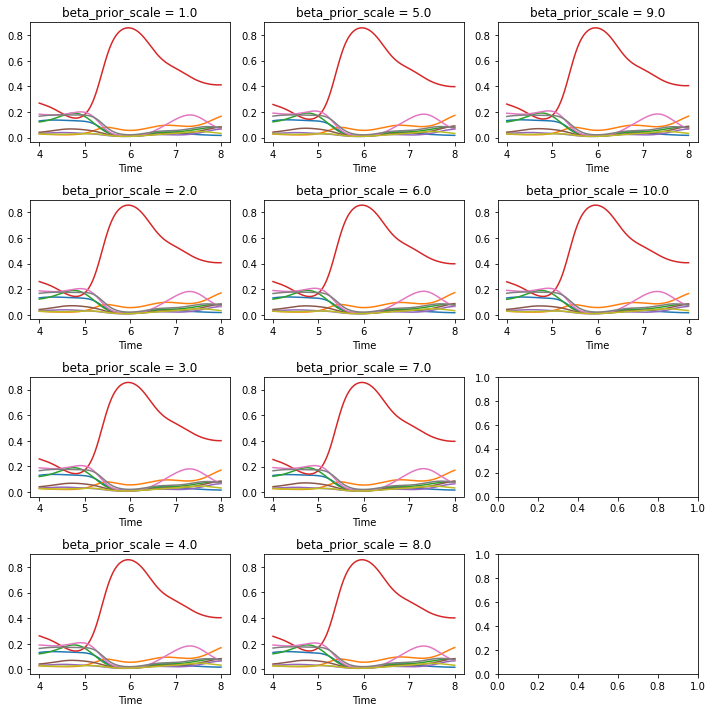

In [11]:
keys = list(results.keys())
n = len(keys)
nr = math.ceil(math.sqrt(n))
nc = math.floor(math.sqrt(n))

fig, ax = matplotlib.pyplot.subplots(nr,nc, figsize=(10,10))

for k in range(len(keys)):
    traj = results[keys[k]]
    cur_ax = ax[k % nr, k // nr]
    cur_ax.plot(
        traj["true_times_z"], traj["norm_comp_tc"],
    )
    cur_ax.set_title(f'beta_prior_scale = {keys[k]}')
    cur_ax.set_xlabel("Time")
    
fig.tight_layout()